In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy
import random
import math
import matplotlib.pyplot as plt
import time
random.seed(0)

# marking the time of the start of the simulation
start = time.time()
# decide how many times I want to check the results 
reps = 100
# Beta represents the inverse temperature, needed for Metropolis algo. This is the 4th approach to simulated annealing, where I hopte to have exponential decay of temperature across the whole of the simulation
beta_start = 0.0001
beta_end = 0.5
alpha = (np.log(1/beta_start)-np.log(1/beta_end))/(reps-1)
gamma = (1/beta_start)*math.exp(alpha)
# How often results should be reported in the ourput window, to avoid overfilling it
report_cycle = 10
# From which rep the results will be graphed, for the ease of reading
graph_results = 0
# We start with the starting beta, but is should also be obtainable from the inverse of the exponentially decaying temperature function, using the obtained alpha and gamma
beta = 1/(gamma*math.exp(-alpha*1))


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# USE DOUBLE FORWARD SLASHES, DESPITE SINGLE SLASHES SHOWN!!!

import os
for dirname, _, filenames in os.walk('/home/ec2-user/SageMaker'): #for dirname, _, filenames in os.walk('C:\\Users\\Maciej Maruszczak\\Documents\\Docs\\Python\\Jupyter\\Kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.getcwd()

# Any results you write to the current directory are saved as output.

/home/ec2-user/SageMaker/family_data.csv
/home/ec2-user/SageMaker/submission_72286.14515830466.csv
/home/ec2-user/SageMaker/V4.1-santa-s-2019-notebook.ipynb
/home/ec2-user/SageMaker/V4.0-santa-s-2019-notebook.ipynb
/home/ec2-user/SageMaker/sample_submission.csv
/home/ec2-user/SageMaker/.ipynb_checkpoints/V4.0-santa-s-2019-notebook-checkpoint.ipynb
/home/ec2-user/SageMaker/.ipynb_checkpoints/V4.1-santa-s-2019-notebook-checkpoint.ipynb


'/home/ec2-user/SageMaker'

## Read in the family information and sample submission

In [2]:
fpath = '/home/ec2-user/SageMaker/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

# CRUCIAL defining which dataset to use, now I can choose from the sample submission or uploaded refined submission
fpath = '/home/ec2-user/SageMaker/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [3]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [4]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(submission)
submission.tail()

,assigned_day
family_id,
4995,5
4996,4
4997,3
4998,2
4999,1


## Create some lookup dictionaries and define constants

In [5]:
# creating a dictionary for the size of a family: an index and the size of the family
family_size_dict = data[['n_people']].to_dict()['n_people']
# creating collumn names for choices, which actually are the same as the headers in the data table, could have use them directly instead
cols = [f'choice_{i}' for i in range(10)]
# creating another dictionaries, first choice_0 for 5000 families, then choice_1 for 5000 families etc.
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125
FAMILIES_NUMBER = 5000
# list of legal occupancy rates
legal_occupancy = list(range(MIN_OCCUPANCY,MAX_OCCUPANCY+1))
print(legal_occupancy)

# from 100 to 1
days = list(range(N_DAYS,0,-1))
# Creates a dictionary of tolarable allocations, i.e. the 10 best choices
tolerance_dict = {}
for f in range(FAMILIES_NUMBER):
    tolerance_dict[f] = data.loc[f, cols].tolist()
print(tolerance_dict)

[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300]
{0: [52, 38, 12, 82, 33, 75, 64, 76, 10, 28], 1: [26, 4, 82, 5, 11, 47, 38, 6, 66, 61], 2: [100, 54, 25, 12, 27, 82, 10

In [6]:
# a function to create a dictionary for a quick lookup of the cost for a single family, to avoid calculating it every time when checked
# It is a static table, which is not changed over in the simulation
# it is NOT, however, a dictionary of the CURRENT COST!
def create_dict_switch(index, fam_size):
    switcher = {
        choice_dict['choice_0'][index]: 0,
        choice_dict['choice_1'][index]: 50,
        choice_dict['choice_2'][index]: 50 + 9 * fam_size,
        choice_dict['choice_3'][index]: 100 + 9 * fam_size,
        choice_dict['choice_4'][index]: 200 + 9 * fam_size,
        choice_dict['choice_5'][index]: 200 + 18 * fam_size,
        choice_dict['choice_6'][index]: 300 + 18 * fam_size,
        choice_dict['choice_7'][index]: 300 + 36 * fam_size,
        choice_dict['choice_8'][index]: 400 + 36 * fam_size,
        choice_dict['choice_9'][index]: 500 + 36 * fam_size + 199 * fam_size,
        999: 500 + 36 * fam_size + 398 * fam_size
    }
    return switcher

# Creating a dictionary of dictionaries for all families, to check their cost quickly
family_size_list = data['n_people'] #.tolist()

day_choice_dict = {}
for f, n in enumerate(family_size_list):
    #print(f)
    day_choice_dict.update({f: create_dict_switch(f, n)})
#print(day_choice_dict)
#%timeit switch.get(12, switch[999])
#%timeit day_choice_dict.get(0, {}).get(52, day_choice_dict[0][999])

In [7]:
# creating a dictionary with all the results from the accounting cost fast calculations
# It is also a STATIC table, not changable over time

def create_account_dict_switch(today_count):
    switcher = {}
    for _, yesterday_count in enumerate(legal_occupancy):
        switcher.update({yesterday_count: max(0, (today_count-125.0) / 400.0 * today_count**(0.5 + abs(today_count - yesterday_count) / 50.0))})
    switcher.update({999: 100000000000000})
    return switcher

# creating a full look-up dictionary for all possible yesterday and todays allocation

accounting_dict = {}
for _, today_count in enumerate(legal_occupancy):
    accounting_dict.update({today_count: create_account_dict_switch(today_count)})
# today first, yesterday second, with illegal allocations giving prohibitive cost
today_count = 200
yesterday_count = 500
accounting_dict.get(today_count, {}).get(yesterday_count, accounting_dict[125][999])

100000000000000

In [8]:
# DYNAMIC dictionaries, which will be changing over time and require updating

# a dictionary for recording the loss of each individual family
dynamic_family_alocation_cost_dict = {}

# a dictionary for recording the current number of people allocated to each day in slow algorythm
daily_occupancy = {k:0 for k in days}

# a dictionary for the accounting cost of all days
dynamic_daily_accounting_cost_dict = {}

# a dictionary for recording which day has which family allocated, an inverse of a submission, with lists for each day outlining which families are within that day

dynamic_daily_family_allocation_dict = {k:[] for k in days}
print(dynamic_daily_family_allocation_dict)
#dynamic_daily_family_allocation_dict.get(100).remove(3)



{100: [], 99: [], 98: [], 97: [], 96: [], 95: [], 94: [], 93: [], 92: [], 91: [], 90: [], 89: [], 88: [], 87: [], 86: [], 85: [], 84: [], 83: [], 82: [], 81: [], 80: [], 79: [], 78: [], 77: [], 76: [], 75: [], 74: [], 73: [], 72: [], 71: [], 70: [], 69: [], 68: [], 67: [], 66: [], 65: [], 64: [], 63: [], 62: [], 61: [], 60: [], 59: [], 58: [], 57: [], 56: [], 55: [], 54: [], 53: [], 52: [], 51: [], 50: [], 49: [], 48: [], 47: [], 46: [], 45: [], 44: [], 43: [], 42: [], 41: [], 40: [], 39: [], 38: [], 37: [], 36: [], 35: [], 34: [], 33: [], 32: [], 31: [], 30: [], 29: [], 28: [], 27: [], 26: [], 25: [], 24: [], 23: [], 22: [], 21: [], 20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: [], 9: [], 8: [], 7: [], 6: [], 5: [], 4: [], 3: [], 2: [], 1: []}


## Cost Function


In [9]:
# a brute force solution, where all data is checked, needed to be ran at least once for the fast algorythm to have the data to use
def cost_function(prediction):
    
    # stating with zero penalty, withich will be added on every step
    penalty = 0

    # As this is full algorythm, I need to make sure that I start with clear occupancy list
    for k in daily_occupancy: daily_occupancy[k] = 0
    # I also need to empty dynamic_daily_family_allocation_dict
    for k in days: dynamic_daily_family_allocation_dict[k] = []
    
    # Looping over each family using enumerate, where the first variable is always the index (family id here, f) and d is the day chosen for each family f. This could also have been used using range() method, but there is no need to do that, and cen refer to f,d directly, wthough searching for it in form of perdiction[index], which could be expensive
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n
        # add the family id to the daily family allocation list, to the appropriate day
        dynamic_daily_family_allocation_dict.get(d).append(f)

        # Calculate the penalty for not getting top preference, and record it in a dictionary
        family_allocation_cost = day_choice_dict.get(f, {}).get(d, day_choice_dict[f][999])
        dynamic_family_alocation_cost_dict.update({f: family_allocation_cost})
        penalty += family_allocation_cost
    
    # the current penalty is the sum of the family allocation cost, which will be needed for fast calculations, added as the 5000th element of the dictionary
    dynamic_family_alocation_cost_dict.update({5000: penalty})

    # I don't need to check total ocupancy, because now this is taken care of by accounting cost dictionary

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = accounting_dict.get(daily_occupancy[days[0]], {}).get(daily_occupancy[days[0]], accounting_dict[125][999])
    # add this accounting daily cost to the dictionary for later use
    dynamic_daily_accounting_cost_dict.update({100: accounting_cost})
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        today_accounting_cost = accounting_dict.get(today_count, {}).get(yesterday_count, accounting_dict[125][999])
        dynamic_daily_accounting_cost_dict.update({day: today_accounting_cost})
        accounting_cost += today_accounting_cost
        yesterday_count = today_count
    
    #print('Slow ocupancy used:',daily_occupancy)
    #print('Slow accoutning cost:', accounting_cost)
    
    # the sum of the dail accounting cost is saved under entry 0
    dynamic_daily_accounting_cost_dict.update({0: accounting_cost})
    penalty += accounting_cost

    return penalty

# before applying the function, I need to change a collumn from panda dataframe to a list, which will basically remove the name of the collumn, "assigned_day", and I need to pass just this, I don't need the indexes, just the assigned day list
test = submission['assigned_day'].tolist()
cost_function(test)
print(dynamic_daily_accounting_cost_dict)
print(dynamic_daily_family_allocation_dict)

{100: 2.906421769117483, 99: 3.8214870533310266, 98: 5.763814458767119, 97: 4.801149179550244, 96: 97.29895117735322, 95: 67.34110726689485, 94: 6.50997443411515, 93: 9.978536195308617, 92: 8.569058404404037, 91: 114.65188831616628, 90: 50.49013876793111, 89: 9.300601504883684, 88: 7.4617540418422, 87: 6.605763339847568, 86: 3.0898155256275075, 85: 7.353005323762492, 84: 4.491193103367592, 83: 5.179729334681488, 82: 3.8685746868145734, 81: 40.13957154466478, 80: 55.43385448135362, 79: 41.22145482732544, 78: 8.923196463695657, 77: 5.935995761908879, 76: 4.122242804711299, 75: 6.766932125021193, 74: 14.406509551484577, 73: 8.040477443204244, 72: 31.815625145183393, 71: 5.881618526948907, 70: 7.244754426795929, 69: 4.061600973703043, 68: 7.267731317841121, 67: 5.0884413530408885, 66: 12.29933189267241, 65: 3.1374353609500165, 64: 17.51552479869857, 63: 4.9965404614419455, 62: 17.494568652490468, 61: 41.802714708814264, 60: 17.312112804179346, 59: 13.20889323897853, 58: 28.273341056445457,

In [10]:
# Let's test if we can find an optimal family to be swapped, using the dictionaries we have created
# Assumed day to which the first family is allocated
test_swap_1_allocation = 44
# Assumed day to which it want's to move, base on its tolerale choice
test_pick = 3
# now we test all the families  within that day (using dynamic_daily_family_allocation_dict) and checking if they can tolerate the new swap (using tolerance_dict)
# Variable indicating that a tolerable swap was found
tolerable_family_found = 0
for _, f in enumerate(dynamic_daily_family_allocation_dict[test_pick]):
    print(f)
    if test_swap_1_allocation in tolerance_dict[f]:
        family_id_2 = f
        print('Found tolerable allocation from family', family_id_2)
        tolerable_family_found = 1
        break
    else:
        print('No tolerable allocation from family', f)
# If no tolerable family found, just try with a random one
if tolerable_family_found == 0:
    family_id_2 = random.choice(dynamic_daily_family_allocation_dict[test_pick])
    print('Random family chosen given no tolerable partner:', family_id_2)
        
        

97
No tolerable allocation from family 97
197
Found tolerable allocation from family 197


In [11]:
# a slow function which does not update dynamic dictionaries, for testing
def cost_function_no_update(prediction):
    
    # stating with zero penalty, withich will be added on every step
    penalty = 0
    
    # Looping over each family using enumerate, where the first variable is always the index (family id here, f) and d is the day chosen for each family f. This could also have been used using range() method, but there is no need to do that, and cen refer to f,d directly, wthough searching for it in form of perdiction[index], which could be expensive
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]

        # Calculate the penalty for not getting top preference, and record it in a dictionary
        family_allocation_cost = day_choice_dict.get(f, {}).get(d, day_choice_dict[f][999])
        #dynamic_family_alocation_cost_dict.update({f: family_allocation_cost})
        penalty += family_allocation_cost
    
    # the current penalty is the sum of the family allocation cost, which will be needed for fast calculations, added as the 5000th element of the dictionary
    #dynamic_family_alocation_cost_dict.update({5000: penalty})

    # I don't need to check total ocupancy, because now this is taken care of by accounting cost dictionary

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = accounting_dict.get(daily_occupancy[days[0]], {}).get(daily_occupancy[days[0]], accounting_dict[125][999])
    # add this accounting daily cost to the dictionary for later use
    #dynamic_daily_accounting_cost_dict.update({100: accounting_cost})
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        today_accounting_cost = accounting_dict.get(today_count, {}).get(yesterday_count, accounting_dict[125][999])
        #dynamic_daily_accounting_cost_dict.update({day: today_accounting_cost})
        accounting_cost += today_accounting_cost
        yesterday_count = today_count
    
    #print('Slow ocupancy used:',daily_occupancy)
    #print('Slow accoutning cost:', accounting_cost)
    
    # the sum of the dail accounting cost is saved under entry 0
    #dynamic_daily_accounting_cost_dict.update({0: accounting_cost})
    penalty += accounting_cost

    return penalty

# before applying the function, I need to change a collumn from panda dataframe to a list, which will basically remove the name of the collumn, "assigned_day", and I need to pass just this, I don't need the indexes, just the assigned day list

In [12]:
# This function uses a temporary prediction, which is a slightly altered version of the actual prediction, which will skip checking all the families and days and will focus only on the change
def fast_cost_function(family_id, prev_alocation, new_alocation):
    
    # stating with allocation penalty stored in the dictionary, which is recorded for the original one
    penalty = dynamic_family_alocation_cost_dict[5000]
    
    # from the family allocation cost dictionary, obtaining what was the previous allocation cost, as it posesses the costs based on the actual, not temporary prediction
    previous_family_allocation_cost = dynamic_family_alocation_cost_dict[family_id]
    #print('Previous family allocation cost:', previous_family_allocation_cost)
    # new allocation cost can be taken directly from the allocation table
    new_family_allocation_cost = day_choice_dict.get(family_id, {}).get(new_alocation, day_choice_dict[family_id][999])
    #print('New family allocation cost:', new_family_allocation_cost)
    # with this, we can calculate the difference in the allocation cost
    allocation_cost_diff = new_family_allocation_cost - previous_family_allocation_cost
    # to get the correct alocation cost for the temporary prediction, the penalty therefore needs to be adjusted 
    penalty += allocation_cost_diff
    # Time for the accounting cost, get the sum which is recorded as the entry zero, to be now updated
    accounting_cost = dynamic_daily_accounting_cost_dict[0]
    # create the differences in the 4 possible days now as zero, in case they would not be altered later in the algorythm, and to update values for testing
    dif_prev_allocation_today_cost = 0
    dif_prev_allocation_tomorrow_cost = 0
    dif_new_allocation_today_cost = 0
    dif_new_allocation_tomorrow_cost = 0
    updated_prev_allocation_today_cost = 0
    updated_prev_allocation_tomorrow_cost = 0
    updated_new_allocation_today_cost = 0
    updated_new_allocation_tomorrow_cost = 0
    # this is the size of the family, which will be used to adjust the two day allocations
    n = family_size_dict[family_id]
    # because I am dealing only with the allocation cost for now, I need to change awkwardly the actual daily occupancy, which is not a good idea because I will need to revert it, as this is based only on the temporary allocation
    daily_occupancy[prev_alocation] -= n
    daily_occupancy[new_alocation] += n
    # checking all possible exceptions for the acounting cost:
    # First check if the previous, normla conde can be applied
    if abs(new_alocation - prev_alocation) != 1:
        # due to the boudary condition, I need to ensure if the new or old allocation is 1 or 100:
        if prev_alocation != 1 and prev_alocation != 100 and new_alocation != 1 and new_alocation != 100:
            # similarily to above, I need to record the 4 days where there is a difference: previous allocation today and tomorrow, and new allocation today and tomorrow
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost    
        #I am following the convention of first checking 1 allocation, then 100, then both. Within each it is first prev, then new then both
        elif prev_alocation == 1 and new_alocation != 1 and new_alocation != 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 1 and prev_alocation != 1 and prev_alocation != 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost    
        elif prev_alocation == 100 and new_alocation != 1 and new_alocation != 100:
            # whenever a 100 is used, a second term of the X_today needs to have +1 removed
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 100 and prev_alocation != 1 and prev_alocation != 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost    
        # now for the mix of the alternative ones, mix the above changes accordingly
        elif prev_alocation == 1 and new_alocation == 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 1 and prev_alocation == 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost    
        # if both of previous and new are the same, just don't do anything, no update is needed
        elif prev_alocation == new_alocation:
            # do nothing
            1 == 1
        else:
            print("blad")
    # Now check the cases where the difference is one, change accordingly to the direction
    elif new_alocation - prev_alocation == 1:
        # Case I, remove all previous updates
        # due to the boudary condition, I need to ensure if the new or old allocation is 1 or 100:
        if prev_alocation != 1 and prev_alocation != 100 and new_alocation != 1 and new_alocation != 100:
            # similarily to above, I need to record the 4 days where there is a difference: previous allocation today and tomorrow, and new allocation today and tomorrow
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            #dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost    
        #I am following the convention of first checking 1 allocation, then 100, then both. Within each it is first prev, then new then both
        elif prev_alocation == 1 and new_alocation != 1 and new_alocation != 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            #dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 1 and prev_alocation != 1 and prev_alocation != 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            #dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost    
        elif prev_alocation == 100 and new_alocation != 1 and new_alocation != 100:
            # whenever a 100 is used, a second term of the X_today needs to have +1 removed
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            #dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 100 and prev_alocation != 1 and prev_alocation != 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            #dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost    
        # now for the mix of the alternative ones, mix the above changes accordingly
        elif prev_alocation == 1 and new_alocation == 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            #dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 1 and prev_alocation == 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            #dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost    
        # if both of previous and new are the same, just don't do anything, no update is needed
        elif prev_alocation == new_alocation:
            # do nothing
            1 == 1
        else:
            print("blad")
    else:
        # Case II remove all new updates
        # due to the boudary condition, I need to ensure if the new or old allocation is 1 or 100:
        if prev_alocation != 1 and prev_alocation != 100 and new_alocation != 1 and new_alocation != 100:
            # similarily to above, I need to record the 4 days where there is a difference: previous allocation today and tomorrow, and new allocation today and tomorrow
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            #updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            #dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost    
        #I am following the convention of first checking 1 allocation, then 100, then both. Within each it is first prev, then new then both
        elif prev_alocation == 1 and new_alocation != 1 and new_alocation != 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            #dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 1 and prev_alocation != 1 and prev_alocation != 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            #dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost    
        elif prev_alocation == 100 and new_alocation != 1 and new_alocation != 100:
            # whenever a 100 is used, a second term of the X_today needs to have +1 removed
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            #dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 100 and prev_alocation != 1 and prev_alocation != 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            #dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost    
        # now for the mix of the alternative ones, mix the above changes accordingly
        elif prev_alocation == 1 and new_alocation == 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            new_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[new_alocation-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation+1], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999]) 
            updated_new_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[new_alocation-1], {}).get(daily_occupancy[new_alocation], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            #dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            dif_new_allocation_tomorrow_cost = updated_new_allocation_tomorrow_cost - new_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        elif new_alocation == 1 and prev_alocation == 100:
            prev_allocation_today_cost = dynamic_daily_accounting_cost_dict[prev_alocation]
            prev_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[prev_alocation-1]
            new_allocation_today_cost = dynamic_daily_accounting_cost_dict[new_alocation]
            # calculate the updated costs, using the updated daily occupancy
            updated_prev_allocation_today_cost = accounting_dict.get(daily_occupancy[prev_alocation], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999])
            updated_prev_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[prev_alocation-1], {}).get(daily_occupancy[prev_alocation], accounting_dict[125][999]) 
            updated_new_allocation_today_cost = accounting_dict.get(daily_occupancy[new_alocation], {}).get(daily_occupancy[new_alocation+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_prev_allocation_today_cost = updated_prev_allocation_today_cost - prev_allocation_today_cost
            dif_prev_allocation_tomorrow_cost = updated_prev_allocation_tomorrow_cost - prev_allocation_tomorrow_cost
            #dif_new_allocation_today_cost = updated_new_allocation_today_cost - new_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost    
        # if both of previous and new are the same, just don't do anything, no update is needed
        elif prev_alocation == new_alocation:
            # do nothing
            1 == 1
        else:
            print("blad")
    
    #print('Fast ocupancy used:', daily_occupancy)
    #print('Fast accoutning cost:', accounting_cost)
    # add the final accounting cost cost adn we are done!
    penalty += accounting_cost
    
    # reverse the temporary allocation
    daily_occupancy[prev_alocation] += n
    daily_occupancy[new_alocation] -= n
    
    #print('Family id:', family_id)
    #print('Proposed move from', prev_alocation, 'to', new_alocation)
    #print('Proposed score:', penalty)
    #print('Proposed changes:', allocation_cost_diff, dif_prev_allocation_today_cost, dif_prev_allocation_tomorrow_cost, dif_new_allocation_today_cost, dif_new_allocation_tomorrow_cost)

        
    return penalty, allocation_cost_diff, dif_prev_allocation_today_cost, dif_prev_allocation_tomorrow_cost, dif_new_allocation_today_cost, dif_new_allocation_tomorrow_cost

# before applying the function, I need to change a collumn from panda dataframe to a list, which will basically remove the name of the collumn, "assigned_day", and I need to pass just this, I don't need the indexes, just the assigned day list
test = submission['assigned_day'].tolist()
current = submission['assigned_day'].tolist()

In [13]:
# Simpler fast cost check
# Run the standard cost function, as usual 
family_id = 94
print(cost_function(test))
# obtaining the previous allocation for the record
prev_alocation = test[family_id]
print('previous allocation:', prev_alocation)
# obtaining the new allocation, I can choose it to be what I want
new_alocation = prev_alocation # choice_dict[f'choice_0'][family_id]
print('new allocation:', new_alocation)
# # Now, we have everything to run the fast code!
fast_check = fast_cost_function(family_id, prev_alocation, new_alocation)[0]
print(fast_check)
#%timeit cost_function(test)
#%timeit fast_cost_function(test, family_id, prev_alocation, new_alocation)

10641498.403135022
previous allocation: 6
new allocation: 6
10641498.403135022


In [14]:
# checking how the two functions, standard and fast compare
family_id =184
# run the standard cost function on the initial function, necessary for the creation of all the dictionaries
print(cost_function(test))
# now, having the dictionaries, we are interested in checking the cost if we would allocate a family to its favourite choice. We first need to create a temporary copy
temp = test.copy()
# obtaining the new allocation, the best for the family 
new_alocation = choice_dict[f'choice_0'][family_id]
print('new allocation:', new_alocation)
# obtaining the previous allocation for the record
prev_alocation = test[family_id]
print('previous allocation:', prev_alocation)
# although I don't think that in this approach I need a temporary prediction, but I will build it for now
temp[family_id] = new_alocation
# Now, we have everything to run the fast code!
fast_check = fast_cost_function(family_id, prev_alocation, new_alocation)
standard_check = cost_function(temp)
print('from fast calculations:', fast_check)
print('standard calculations:', standard_check)
print('the difference:', fast_check[0] - standard_check)
#standard_check = cost_function(temp)
#fast_check = fast_cost_function(temp, family_id, old_alocation, new_alocation)
#%timeit fast_cost_function(temp, family_id, old_alocation, new_alocation)
#%timeit cost_function(temp)

10641498.403135022
new allocation: 4
previous allocation: 16
from fast calculations: (10638413.61673906, -3104, 6.549361889797362, 4.931305072453781, -0.6684035425200117, 8.401340617867218)
standard calculations: 10638413.61673906
the difference: 0.0


In [15]:
# As fast algorythm does not update dynamical dictionaries, once the change is accepted a separate function deals with the dynamical dictionaries update, which is defined below.

def dyn_dict_fast_update(family_id, prev_alocation, new_alocation, allocation_cost_diff, dif_prev_allocation_today_cost, dif_prev_allocation_tomorrow_cost, dif_new_allocation_today_cost, dif_new_allocation_tomorrow_cost):
    #print('FOLLOWING CHANGES ACCEPTED:', allocation_cost_diff, dif_prev_allocation_today_cost, dif_prev_allocation_tomorrow_cost, dif_new_allocation_today_cost, dif_new_allocation_tomorrow_cost)
    #print('COST BEFORE UPDATE:', dynamic_family_alocation_cost_dict[5000] + dynamic_daily_accounting_cost_dict[0])
    # First, allocation cost: updating the sum using the difference...
    dynamic_family_alocation_cost_dict[5000] += allocation_cost_diff
    # The cost of the individual family also needs to be updated, by the same amount (as the last entry is the sum of the previous ones)
    dynamic_family_alocation_cost_dict[family_id] += allocation_cost_diff
    # For the accounting cost, allocation to/from 1 is only a problem, not to a 100, so need to control for the cases when 1 is in allocation
    if prev_alocation != 1 and new_alocation != 1:
        # The simplest case, update the sum and all 4 entries:
        dynamic_daily_accounting_cost_dict[0] += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[prev_alocation] += dif_prev_allocation_today_cost
        dynamic_daily_accounting_cost_dict[prev_alocation-1] += dif_prev_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[new_alocation] += dif_new_allocation_today_cost
        dynamic_daily_accounting_cost_dict[new_alocation-1] += dif_new_allocation_tomorrow_cost
        # SCREAM IF NEGATIVE ADMIN COST HAPPENED!
        if dynamic_daily_accounting_cost_dict[prev_alocation] < 0 or dynamic_daily_accounting_cost_dict[prev_alocation-1] < 0 or dynamic_daily_accounting_cost_dict[new_alocation] < 0 or dynamic_daily_accounting_cost_dict[new_alocation-1] < 0:
            print(dynamic_daily_accounting_cost_dict[prev_alocation], dynamic_daily_accounting_cost_dict[prev_alocation-1], dynamic_daily_accounting_cost_dict[new_alocation], dynamic_daily_accounting_cost_dict[new_alocation-1])
            print(dynamic_daily_accounting_cost_dict)
            print('**********************************************')
            print('**************** ERROR ABOVE 0 ! *****************')
            for a in range(100):
                print('**********************************************')
    # do not make one update when the day 1 is used
    elif prev_alocation == 1:
        dynamic_daily_accounting_cost_dict[0] += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[prev_alocation] += dif_prev_allocation_today_cost
        dynamic_daily_accounting_cost_dict[new_alocation] += dif_new_allocation_today_cost
        dynamic_daily_accounting_cost_dict[new_alocation-1] += dif_new_allocation_tomorrow_cost
        if dynamic_daily_accounting_cost_dict[prev_alocation] < 0 or dynamic_daily_accounting_cost_dict[new_alocation] < 0 or dynamic_daily_accounting_cost_dict[new_alocation-1] < 0:
            print(dynamic_daily_accounting_cost_dict[prev_alocation], dynamic_daily_accounting_cost_dict[new_alocation], dynamic_daily_accounting_cost_dict[new_alocation-1])
            print(dynamic_daily_accounting_cost_dict)
            print('**********************************************')
            print('**************** ERROR ABOVE 1 ! *****************')
            for a in range(100):
                print('**********************************************')
    elif new_alocation == 1:
        dynamic_daily_accounting_cost_dict[0] += dif_prev_allocation_today_cost + dif_prev_allocation_tomorrow_cost + dif_new_allocation_today_cost + dif_new_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[prev_alocation] += dif_prev_allocation_today_cost
        dynamic_daily_accounting_cost_dict[prev_alocation-1] += dif_prev_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[new_alocation] += dif_new_allocation_today_cost
        if dynamic_daily_accounting_cost_dict[prev_alocation] < 0 or dynamic_daily_accounting_cost_dict[prev_alocation-1] < 0 or dynamic_daily_accounting_cost_dict[new_alocation] < 0:
            print(dynamic_daily_accounting_cost_dict[prev_alocation], dynamic_daily_accounting_cost_dict[prev_alocation-1], dynamic_daily_accounting_cost_dict[new_alocation])
            print(dynamic_daily_accounting_cost_dict)
            print('**********************************************')
            print('**************** ERROR ABOVE 2 ! *****************')
            for a in range(100):
                print('**********************************************')
    # If both are one, just don't make an update, not needed as it is the same day
    elif prev_alocation == 1 and new_alocation == 1:
        1 == 1
    # Safety catch
    else:
        print("blad")
    # Update dynamic_daily_family_allocation_dict, by removing the family id from the previous allocation and add it to the new one
    #print('Family ID:', family_id)
    #print('Previous allocation:', prev_alocation)
    #('New allocation:', new_alocation)
    #print('Dictionary:', dynamic_daily_family_allocation_dict)
    dynamic_daily_family_allocation_dict.get(prev_alocation).remove(family_id)
    dynamic_daily_family_allocation_dict.get(new_alocation).append(family_id)

    # Finally, update daily occupancy, which is the last dynamic dictionary
    n = family_size_dict[family_id]
    daily_occupancy[prev_alocation] -= n
    daily_occupancy[new_alocation] += n
    #print('COST AFTER UPDATE:', dynamic_family_alocation_cost_dict[5000] + dynamic_daily_accounting_cost_dict[0])
        

## Opimization

In [16]:
# Let's introduce swaps of families:

# 1. Give two families which are proposed for swapping (I don't need any other algorythm as in fact all other information will be recorded in the dynamic dictionaries)
# 2. Two allocation costs to be updated
# 3. Four-Two accounting costs to e updated, like before
# 4. Make an update swapping function like before

# a fast function which takes calculates the cost after swaping two families
def fast_cost_function_swap(family_id_1, family_id_2):
    
    # stating with allocation penalty stored in the dictionary, which is recorded for the original one
    penalty = dynamic_family_alocation_cost_dict[5000]
    
    # from the family allocation cost dictionary, obtaining what was the allocation cost of the two families
    family_allocation_cost_1 = dynamic_family_alocation_cost_dict[family_id_1]
    family_allocation_cost_2 = dynamic_family_alocation_cost_dict[family_id_2]
    #print('Previous family 1 allocation cost:', family_allocation_cost_1)
    #print('Previous family 2 allocation cost:', family_allocation_cost_2)
    # obtaining the previous allocations of the two families
    previous_family_allocation_1 = current[family_id_1]
    previous_family_allocation_2 = current[family_id_2]
    #print('Previous family 1 allocation:', previous_family_allocation_1)
    #print('Previous family 2 allocation:', previous_family_allocation_2)
    # new allocation cost can be taken directly from the allocation table, from both families, using the previous allocation of the other family, instead of a given input value
    new_family_allocation_cost_1 = day_choice_dict.get(family_id_1, {}).get(previous_family_allocation_2, day_choice_dict[family_id_1][999])
    new_family_allocation_cost_2 = day_choice_dict.get(family_id_2, {}).get(previous_family_allocation_1, day_choice_dict[family_id_2][999])
    #print('New family 1 allocation cost:', new_family_allocation_cost_1)
    #print('New family 2 allocation cost:', new_family_allocation_cost_2)
    # with this, we can calculate the difference in the allocation costs for both families
    family_allocation_cost_diff_1 = new_family_allocation_cost_1 - family_allocation_cost_1
    family_allocation_cost_diff_2 = new_family_allocation_cost_2 - family_allocation_cost_2
    #print('Family 1 allocation cost difference:', family_allocation_cost_diff_1)
    #print('Family 2 allocation cost difference:', family_allocation_cost_diff_2)
    allocation_cost_diff = family_allocation_cost_diff_1 + family_allocation_cost_diff_2
    # to get the correct alocation cost for the temporary prediction, the penalty therefore needs to be adjusted 
    #print('Starting penalty:', penalty)
    penalty += allocation_cost_diff
    #print('Penalty after updating allocation cost:', penalty)
    # Time for the accounting cost, get the sum which is recorded as the entry zero, to be now updated
    accounting_cost = dynamic_daily_accounting_cost_dict[0]
    # create the differences in the 4 possible days now as zero, in case they would not be altered later in the algorythm, and to update values for testing
    dif_family_1_allocation_today_cost = 0.
    dif_family_1_allocation_tomorrow_cost = 0.
    dif_family_2_allocation_today_cost = 0.
    dif_family_2_allocation_tomorrow_cost = 0.
    updated_family_1_allocation_today_cost = 0.
    updated_family_1_allocation_tomorrow_cost = 0.
    updated_family_2_allocation_today_cost = 0.
    updated_family_2_allocation_tomorrow_cost = 0.

    # this is the size of the two families, which will be used to adjust the two day allocations
    n1 = family_size_dict[family_id_1]
    n2 = family_size_dict[family_id_2]
    #print('Family 1 size:', n1)
    #print('Family 2 size:', n2)
    # because I am dealing only with the allocation cost for now, I need to change awkwardly the actual daily occupancy, which is not a good idea because I will need to revert it, as this is based only on the temporary allocation
    daily_occupancy[previous_family_allocation_1] += n2-n1
    daily_occupancy[previous_family_allocation_2] += n1-n2
    # checking all possible exceptions for the acounting cost:
    # First check if the previous, normal conde can be applied
    if abs(previous_family_allocation_2 - previous_family_allocation_1) != 1:
        # due to the boudary condition, I need to ensure if the new or old allocation is 1 or 100:
        if previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # similarily to above, I need to record the 4 days where there is a difference: previous allocation today and tomorrow, and new allocation today and tomorrow
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost    
        #I am following the convention of first checking 1 allocation, then 100, then both. Within each it is first prev, then new then both
        elif previous_family_allocation_1 == 1 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 1 and previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost    
        elif previous_family_allocation_1 == 100 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # whenever a 100 is used, a second term of the X_today needs to have +1 removed
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 100 and previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost    
        # now for the mix of the alternative ones, mix the above changes accordingly
        elif previous_family_allocation_1 == 1 and previous_family_allocation_2 == 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 1 and previous_family_allocation_1 == 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost    
        # if both of previous and new are the same, just don't do anything, no update is needed
        elif previous_family_allocation_1 == previous_family_allocation_2:
            # do nothing
            1 == 1
        else:
            print("blad")
    # Now check the cases where the difference is one, change accordingly to the direction
    elif previous_family_allocation_2 - previous_family_allocation_1 == 1:
        # Case I, remove all previous updates
        # due to the boudary condition, I need to ensure if the new or old allocation is 1 or 100:
        if previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # similarily to above, I need to record the 4 days where there is a difference: previous allocation today and tomorrow, and new allocation today and tomorrow
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            #dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost    
        #I am following the convention of first checking 1 allocation, then 100, then both. Within each it is first prev, then new then both
        elif previous_family_allocation_1 == 1 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            #dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 1 and previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            #dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost    
        elif previous_family_allocation_1 == 100 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # whenever a 100 is used, a second term of the X_today needs to have +1 removed
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            #dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 100 and previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            #dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost    
        # now for the mix of the alternative ones, mix the above changes accordingly
        elif previous_family_allocation_1 == 1 and previous_family_allocation_2 == 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            #dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 1 and previous_family_allocation_1 == 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            #dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost    
        # if both of previous and new are the same, just don't do anything, no update is needed
        elif previous_family_allocation_1 == previous_family_allocation_2:
            # do nothing
            1 == 1
        else:
            print("blad")
    else:
        # Case II remove all new updates
        # due to the boudary condition, I need to ensure if the new or old allocation is 1 or 100:
        if previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # similarily to above, I need to record the 4 days where there is a difference: previous allocation today and tomorrow, and new allocation today and tomorrow
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            #updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            #dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost    
        #I am following the convention of first checking 1 allocation, then 100, then both. Within each it is first prev, then new then both
        elif previous_family_allocation_1 == 1 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            #dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 1 and previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            #dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost    
        elif previous_family_allocation_1 == 100 and previous_family_allocation_2 != 1 and previous_family_allocation_2 != 100:
            # whenever a 100 is used, a second term of the X_today needs to have +1 removed
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            #dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 100 and previous_family_allocation_1 != 1 and previous_family_allocation_1 != 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            #dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 4 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost    
        # now for the mix of the alternative ones, mix the above changes accordingly
        elif previous_family_allocation_1 == 1 and previous_family_allocation_2 == 100:
            # Whenever an allocation is 1, it means that there will be only three elements
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            family_2_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1+1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999]) 
            updated_family_2_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2-1], {}).get(daily_occupancy[previous_family_allocation_2], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            #dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            dif_family_2_allocation_tomorrow_cost = updated_family_2_allocation_tomorrow_cost - family_2_allocation_tomorrow_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        elif previous_family_allocation_2 == 1 and previous_family_allocation_1 == 100:
            family_1_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1]
            family_1_allocation_tomorrow_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1]
            family_2_allocation_today_cost = dynamic_daily_accounting_cost_dict[previous_family_allocation_2]
            # calculate the updated costs, using the updated daily occupancy
            updated_family_1_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999])
            updated_family_1_allocation_tomorrow_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_1-1], {}).get(daily_occupancy[previous_family_allocation_1], accounting_dict[125][999]) 
            updated_family_2_allocation_today_cost = accounting_dict.get(daily_occupancy[previous_family_allocation_2], {}).get(daily_occupancy[previous_family_allocation_2+1], accounting_dict[125][999])
            # with these 4 costs, we can calculate the difference in each four
            dif_family_1_allocation_today_cost = updated_family_1_allocation_today_cost - family_1_allocation_today_cost
            dif_family_1_allocation_tomorrow_cost = updated_family_1_allocation_tomorrow_cost - family_1_allocation_tomorrow_cost
            #dif_family_2_allocation_today_cost = updated_family_2_allocation_today_cost - family_2_allocation_today_cost
            # Update the previous accounting cost by these 3 differences
            accounting_cost += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost    
        # if both of previous and new are the same, just don't do anything, no update is needed
        elif previous_family_allocation_1 == previous_family_allocation_2:
            # do nothing
            1 == 1
        else:
            print("blad")
    
    #print('Fast ocupancy used:', daily_occupancy)
    #print('Fast accoutning cost:', accounting_cost)
    # add the final accounting cost cost adn we are done!
    penalty += accounting_cost
    
    # reverse the temporary allocation
    daily_occupancy[previous_family_allocation_1] -= n2-n1
    daily_occupancy[previous_family_allocation_2] -= n1-n2
    
    #print('Family 1 allocation cost difference at the end of algo:', family_allocation_cost_diff_1)
    #print('Family 2 allocation cost difference at the end of algo:', family_allocation_cost_diff_2)
    #print('Accounting cost differences:', family_allocation_cost_diff_2, dif_family_1_allocation_today_cost, dif_family_1_allocation_tomorrow_cost, dif_family_2_allocation_today_cost, dif_family_2_allocation_tomorrow_cost)
    
    return penalty, family_allocation_cost_diff_1, family_allocation_cost_diff_2, dif_family_1_allocation_today_cost, dif_family_1_allocation_tomorrow_cost, dif_family_2_allocation_today_cost, dif_family_2_allocation_tomorrow_cost

In [17]:
# checking how the two functions, fast swap and standard compare
# run the standard cost function on the initial allocation, necessary for the creation of all the dictionaries
print(cost_function(current))
# define which two families will be swapped
family_id_1 = 56
family_id_2 = 77
# now, having the dictionaries, we are interested in checking the cost after the two families are swaped. With the fast swap function, I can run it straight with just the two family IDs
fast_check = fast_cost_function_swap(family_id_1, family_id_2)
# swapping the allocation in the temporary allocation array, for the slow cost function to work
temp = current.copy()
temp[family_id_1] = current[family_id_2]
temp[family_id_2] = current[family_id_1]
# Now, we have everything to run the slow code!
standard_check = cost_function(temp)
print('from fast calculations:', fast_check)
print('standard calculations:', standard_check)
print('the difference:', fast_check[0] - standard_check)
#standard_check = cost_function(temp)
#fast_check = fast_cost_function(temp, family_id, old_alocation, new_alocation)
#%timeit fast_cost_function(temp, family_id, old_alocation, new_alocation)
#%timeit cost_function(temp)

10641498.403135022
from fast calculations: (10641490.046564652, 0, 0, -4.1430249823816006, -1.6719626727688581, -0.6971947057560435, -1.8443880098270462)
standard calculations: 10641490.046564652
the difference: 0.0


In [18]:
# As fast swap algorythm does not update dynamical dictionaries, once the change is accepted a separate function deals with the dynamical dictionaries update, which is defined below.

def dyn_dict_fast_update_swap(family_id_1, family_id_2,  family_allocation_cost_diff_1, family_allocation_cost_diff_2, dif_family_1_allocation_today_cost, dif_family_1_allocation_tomorrow_cost, dif_family_2_allocation_today_cost, dif_family_2_allocation_tomorrow_cost):
    #print('FOLLOWING CHANGES ACCEPTED:', family_allocation_cost_diff_1, family_allocation_cost_diff_2, dif_family_1_allocation_today_cost, dif_family_1_allocation_tomorrow_cost, dif_family_2_allocation_today_cost, dif_family_2_allocation_tomorrow_cost)
    #print('COST BEFORE UPDATE:', dynamic_family_alocation_cost_dict[5000] + dynamic_daily_accounting_cost_dict[0])
    # First, allocation cost: updating the sum using the difference for the two families
    dynamic_family_alocation_cost_dict[5000] += family_allocation_cost_diff_1 + family_allocation_cost_diff_2
    # The costs of the individual families also need to be updated
    dynamic_family_alocation_cost_dict[family_id_1] += family_allocation_cost_diff_1
    dynamic_family_alocation_cost_dict[family_id_2] += family_allocation_cost_diff_2
    
    # As they are not passed, the previous allocations from the current allocation array need to be checked
    previous_family_allocation_1 = current[family_id_1]
    previous_family_allocation_2 = current[family_id_2]
    #print('Family 1 allocation in dict update function:', previous_family_allocation_1)
    #print('Family 2 allocation in dict update function:', previous_family_allocation_2)
    # For the accounting cost, allocation to/from 1 is only a problem, not to a 100, so need to control for the cases when 1 is in allocation
    if previous_family_allocation_1 != 1 and previous_family_allocation_2 != 1:
        # The simplest case, update the sum and all 4 entries:
        dynamic_daily_accounting_cost_dict[0] += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_1] += dif_family_1_allocation_today_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1] += dif_family_1_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_2] += dif_family_2_allocation_today_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1] += dif_family_2_allocation_tomorrow_cost
        # SCREAM IF NEGATIVE ACCOUNTING COST APPEARS
        if dynamic_daily_accounting_cost_dict[previous_family_allocation_1] < 0 or dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1] < 0 or dynamic_daily_accounting_cost_dict[previous_family_allocation_2] < 0 or dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1] < 0:
            print(dynamic_daily_accounting_cost_dict[previous_family_allocation_1], dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1], dynamic_daily_accounting_cost_dict[previous_family_allocation_2], dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1])
            print(dynamic_daily_accounting_cost_dict)
            print('**********************************************')
            print('****************  SWAP ERROR ABOVE 1 ! *****************')
            for a in range(100):
                print('**********************************************')
    # do not make one update when the day 1 is used
    elif previous_family_allocation_1 == 1:
        dynamic_daily_accounting_cost_dict[0] += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_1] += dif_family_1_allocation_today_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_2] += dif_family_2_allocation_today_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1] += dif_family_2_allocation_tomorrow_cost
        # SCREAM IF NEGATIVE ACCOUNTING COST APPEARS
        if dynamic_daily_accounting_cost_dict[previous_family_allocation_1] < 0 or dynamic_daily_accounting_cost_dict[previous_family_allocation_2] < 0 or dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1] < 0:
            print(dynamic_daily_accounting_cost_dict[previous_family_allocation_1], dynamic_daily_accounting_cost_dict[previous_family_allocation_2], dynamic_daily_accounting_cost_dict[previous_family_allocation_2-1])
            print(dynamic_daily_accounting_cost_dict)
            print('**********************************************')
            print('****************  SWAP ERROR ABOVE 2 ! *****************')
            for a in range(100):
                print('**********************************************')
    elif previous_family_allocation_2 == 1:
        dynamic_daily_accounting_cost_dict[0] += dif_family_1_allocation_today_cost + dif_family_1_allocation_tomorrow_cost + dif_family_2_allocation_today_cost + dif_family_2_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_1] += dif_family_1_allocation_today_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1] += dif_family_1_allocation_tomorrow_cost
        dynamic_daily_accounting_cost_dict[previous_family_allocation_2] += dif_family_2_allocation_today_cost
        # SCREAM IF NEGATIVE ACCOUNTING COST APPEARS
        if dynamic_daily_accounting_cost_dict[previous_family_allocation_1] < 0 or dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1] < 0 or dynamic_daily_accounting_cost_dict[previous_family_allocation_2] < 0:
            print(dynamic_daily_accounting_cost_dict[previous_family_allocation_1], dynamic_daily_accounting_cost_dict[previous_family_allocation_1-1], dynamic_daily_accounting_cost_dict[previous_family_allocation_2])
            print(dynamic_daily_accounting_cost_dict)
            print('**********************************************')
            print('****************  SWAP ERROR ABOVE 3 ! *****************')
            for a in range(100):
                print('**********************************************')

    # If both are one, just don't make an update, not needed as it is the same day
    elif previous_family_allocation_1 == 1 and previous_family_allocation_2 == 1:
        1 == 1
    # Safety catch
    else:
        print("blad")
    # Update dynamic_daily_family_allocation_dict, by removing the families ids from the previous allocations and add them to the new ones, if the two families are different
    
    if family_id_1 != family_id_2:
        dynamic_daily_family_allocation_dict.get(previous_family_allocation_1).remove(family_id_1)
        dynamic_daily_family_allocation_dict.get(previous_family_allocation_2).remove(family_id_2)
        dynamic_daily_family_allocation_dict.get(previous_family_allocation_2).append(family_id_1)
        dynamic_daily_family_allocation_dict.get(previous_family_allocation_1).append(family_id_2)
    # Finally, update daily occupancy, which is the last dynamic dictionary, using the size of two families
    # this is the size of the two families, which will be used to adjust the two day allocations
    n1 = family_size_dict[family_id_1]
    n2 = family_size_dict[family_id_2]
    daily_occupancy[previous_family_allocation_1] += n2-n1
    daily_occupancy[previous_family_allocation_2] += n1-n2
    #print('COST AFTER UPDATE:', dynamic_family_alocation_cost_dict[5000] + dynamic_daily_accounting_cost_dict[0])
        

In [19]:
# testing the new swap function and the update

# run the standard cost function on the initial allocation, necessary for the creation of all the dictionaries
print(cost_function(current))
# define which two families will be swapped
family_id_1 = 0
family_id_2 = 2
# now, having the dictionaries, we are interested in checking the cost after the two families are swaped. With the fast swap function, I can run it straight with just the two family IDs
fast_check = fast_cost_function_swap(family_id_1, family_id_2)
# swapping the allocation in the temporary allocation array, for the slow cost function to work
temp = current.copy()
temp[family_id_1] = current[family_id_2]
temp[family_id_2] = current[family_id_1]

print('from fast calculations:', fast_check)
# update the dictionaries, as we assume the it was accepted
dyn_dict_fast_update_swap(family_id_1, family_id_2, fast_check[1], fast_check[2], fast_check[3], fast_check[4], fast_check[5], fast_check[6])
# Now, we have everything to run the slow code!
standard_check = cost_function(temp)
print('standard calculations:', standard_check)
print('the difference:', fast_check[0] - standard_check)
#standard_check = cost_function(temp)
#fast_check = fast_cost_function(temp, family_id, old_alocation, new_alocation)
#%timeit fast_cost_function(temp, family_id, old_alocation, new_alocation)
#%timeit cost_function(temp)

10641498.403135022
from fast calculations: (10639697.2599907, 0, -1802, -0.04285755646221201, -0.3852551012697689, 0.7461599753480304, 0.5388083599842375)
standard calculations: 10639697.2599907
the difference: 0.0


In [20]:
# Here I am adding the arrays for recording the effectiveness of 1way and swap operations

# Defining the "memory" for how long the array will remember what the effect was (initially assume all checks were working)
memory_length = 10
# Defining 1way to swap cost, to increase the value of swaps
swap_to_1way_cost = 10
# boundary for the minimum swap probability, to not remove it completely
min_swap_p = 0.05
# boundary for max swap_p, to not remove them all when 10 failed 1 way allocations would happen
max_swap_p = 0.95
# small epsilon to avoid dividing by zero
epsilon = 0.000001
succ_list_1way = [1 for i in range(memory_length)]
succ_list_swap = [1 for i in range(memory_length)]
print(succ_list_1way)
# we now calculate the effectiveness based on two arrays (could be made more efficient for longer arrays)
effect_1way = sum(succ_list_1way) / memory_length
effect_swap = sum(succ_list_swap) / memory_length
print(effect_1way)
# now calculate swap probability, based on the effectiveness and the 1way to swap cost
swap_p = min(max_swap_p,max(min_swap_p, 1/(1+(effect_1way+epsilon)/(effect_swap*swap_to_1way_cost+epsilon))))
print('Initial swap_p:',swap_p)
# All the variabless needed for choosing the 1way change
memory_length_1way = 100
# minimum and maximum pick probabilities
#min_pick_1way_p = 0.01
#max_pick_1way_p = 0.9
# A bias term which is added to the effectiveness, the larger it is the less responsive is the pick probabilit is to changes in sucess rate, it also specifies a minimum probability, should not be set to zero as it also works as epsilon
bias_pick_1way = 0.1
# creating the success list, 2d array, for each of the possible picks
succ_list_pick_1way = [[1 for i in range(memory_length_1way)] for j in range(10)]#[[1 for i in range(memory_length_1way)], [1 for i in range(memory_length_1way)]]
print(succ_list_pick_1way)
print(succ_list_pick_1way[0])
# list of effectiveness of all picks, based on the successful pick list
effect_pick_1way = [(sum(succ_list_pick_1way[i])+bias_pick_1way) / memory_length_1way for i in range(10)]
print(effect_pick_1way)
# calculating probabilities based on the effectiveness, no constrains so far
# the sum of the effect_pick_1way, which is a denominator used in standardisation
denominator = sum(effect_pick_1way)
pick_1way_p = [effect_pick_1way[i]/denominator for i in range(10)]
print(pick_1way_p)
# get a random sample ased on these probabilities
pick = np.random.choice(10,1, p=pick_1way_p)[0]
print(pick)
# lets say that the picked value has failed, so the effectiveness list needs to be updated with zero
succ_list_pick_1way[pick].insert(0, 0)
del succ_list_pick_1way[pick][memory_length_1way]
print(succ_list_pick_1way)
# add two more fails
succ_list_pick_1way[pick].insert(0, 0)
del succ_list_pick_1way[pick][memory_length_1way]
print(succ_list_pick_1way)
succ_list_pick_1way[pick].insert(0, 0)
del succ_list_pick_1way[pick][memory_length_1way]
print(succ_list_pick_1way)
# calculating the new probabilities now
effect_pick_1way = [(sum(succ_list_pick_1way[i])+bias_pick_1way) / memory_length_1way for i in range(10)]
print(effect_pick_1way)
# calculating probabilities based on the effectiveness, no constrains so far
# the sum of the effect_pick_1way, which is a denominator used in standardisation
denominator = sum(effect_pick_1way)
pick_1way_p = [effect_pick_1way[i]/denominator for i in range(10)]
print(pick_1way_p)
# get a random sample ased on these probabilities
pick = np.random.choice(10,1, p=pick_1way_p)[0]
print(pick)



# # testing adding a new element in swap list (failure, 0) and shifting all back (first is the position, then value)
# succ_list_swap.insert(0, 0)
# del succ_list_swap[memory]
# print(succ_list_swap)
# # we now calculate the effectiveness based on two arrays
# effect_1way = sum(succ_list_1way) / memory_length
# effect_swap = sum(succ_list_swap) / memory_length
# # now calculate swap probability, based on the effectiveness and the 1way to swap cost
# swap_p = max(min_swap_p, 1/(1+effect_1way/(effect_swap*swap_to_1way_cost+epsilon)))
# print('Swap_p after one failure:',swap_p)
# # assume that next 8 updates were failures:
# succ_list_swap = [0,0,0,0,0,0,0,0,0,1]
# # we now calculate the effectiveness based on two arrays
# effect_1way = sum(succ_list_1way) / memory_length
# effect_swap = sum(succ_list_swap) / memory_length
# # now calculate swap probability, based on the effectiveness and the 1way to swap cost
# swap_p = max(min_swap_p, 1/(1+effect_1way/(effect_swap*swap_to_1way_cost+epsilon)))
# print('Swap_p after 9 failures:',swap_p)
# # adding the final fail, which should triger the minimum
# succ_list_swap.insert(0, 0)
# del succ_list_swap[memory]
# print(succ_list_swap)
# # we now calculate the effectiveness based on two arrays
# effect_1way = sum(succ_list_1way) / memory_length
# effect_swap = sum(succ_list_swap) / memory_length
# # now calculate swap probability, based on the effectiveness and the 1way to swap cost
# swap_p = max(min_swap_p, 1/(1+effect_1way/(effect_swap*swap_to_1way_cost+epsilon)))
# print('Swap_p after 10 failures:',swap_p)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1.0
Initial swap_p: 0.9090908347107572
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1

In [21]:

# Start with the sample submission values
# Arrays for reporting results
best_cost_history = []
current_cost_history = []
optimal_1way_update_history = []
suboptimal_1way_update_history = []
optimal_swap_update_history = []
suboptimal_swap_update_history = []
beta_history = []
temperature_history = []
# chop the collumn name by moving it into a list
best = submission['assigned_day'].tolist()
# calculate that initial score, which is the currently best score, using the slow version of cost function
best_cost = cost_function(best)
# With Metropolis algo, suboptimal transitions are possible, so there is a difference between the best allocation and the current allocation
current = submission['assigned_day'].tolist()
# calculate the initial, also best score
current_cost = cost_function(current)

print('Beta:', beta)
# initial probability of swap happening, instead of a usual check
swap_p = 0.5
for a in range(reps):
    # counters for this rep
    optimal_1way_counter = 0
    suboptimal_1way_counter = 0
    swap_counter = 0
    optimal_swap_counter = 0
    suboptimal_swap_counter = 0
    # counter checking how many 1way changes were attempted
    counter_1way = 0
    # as we have the possibility of swaps, which I want to count seperatelly, we will be doing a rep until 5000 families were checked (so on average each family was check once, but not necessarily each one in particular)
    while counter_1way < FAMILIES_NUMBER:
        # check if the random roll is below the probability of a swap- do a swap if so and usual comparison otherwise
        #print('Current swap probability:', swap_p)
        if random.random() < swap_p:
            # update local counter
            swap_counter += 1
            # pick one family randomly
            swap_family_id_1 = random.randint(0, FAMILIES_NUMBER-1)
            # get its allocation
            current_allocation_family_1 = current[swap_family_id_1]
            # pick randomly which day out of 10 favourites will be chosen for swapping
            pick = random.randint(0, 9)
            # Find which day out of the 100 this day actually is, which will be the current allocation of the other swapping family, id 2
            current_allocation_family_2 = choice_dict[f'choice_{pick}'][swap_family_id_1]
            # Now we know with which day we will be swapping, we test all the families within that day (using dynamic_daily_family_allocation_dict) and checking if they can tolerate the new swap (using tolerance_dict)
            # Variable indicating that a tolerable swap was found
            tolerable_family_found = 0
            # Enumerating over all families allocated to the chosen day
            for _, f in enumerate(dynamic_daily_family_allocation_dict[current_allocation_family_2]):
                #print(f)
                # If the current allocation of the family 1 is in the tolerance of the family 2, we found our second swapping family
                if current_allocation_family_1 in tolerance_dict[f]:
                    swap_family_id_2 = f
                    #print('Found tolerable allocation from family', swap_family_id_2)
                    tolerable_family_found = 1
                    break
                #else:
                    #print('No tolerable allocation from family', f)
            # If no tolerable family found, just try with a random one
            if tolerable_family_found == 0:
                swap_family_id_2 = random.choice(dynamic_daily_family_allocation_dict[current_allocation_family_2])
                #print('Random family chosen given no tolerable swap partner:', swap_family_id_2)
            ## Choose a random family allocated this day, using dynamic_daily_family_allocation_dict, to be swapped with the first one
            #swap_family_id_2 = random.choice(dynamic_daily_family_allocation_dict.get(swapping_alocation))
            #swap_family_id_1 = random.randint(0, FAMILIES_NUMBER-1)
            #swap_family_id_2 = random.randint(0, FAMILIES_NUMBER-1)
            # calculate the temporary cost using fast swap function
            temp_cost, family_allocation_cost_diff_1, family_allocation_cost_diff_2, dif_family_1_allocation_today_cost, dif_family_1_allocation_tomorrow_cost, dif_family_2_allocation_today_cost, dif_family_2_allocation_tomorrow_cost = fast_cost_function_swap(swap_family_id_1, swap_family_id_2) 
            if temp_cost <= current_cost:
                # update the successfull counter and the list of successes for swaps
                optimal_swap_counter += 1
                #succ_list_swap.insert(0, 1)
                #del succ_list_swap[memory_length]
                #print('Successful swap change')
                #print('Optimal swap allocation made')
                # with the fast code, I also need to update the dictionaries with the function designed for this purpose (needs to happen before changes to the current as it uses it to get the allocations)
                dyn_dict_fast_update_swap(swap_family_id_1, swap_family_id_2, family_allocation_cost_diff_1, family_allocation_cost_diff_2, dif_family_1_allocation_today_cost, dif_family_1_allocation_tomorrow_cost, dif_family_2_allocation_today_cost, dif_family_2_allocation_tomorrow_cost)
                # update the two allocation for the two families, i.e. swap them, by first recording what are they current allocations
                prev_allocation_family_1 = current[swap_family_id_1]
                prev_allocation_family_2 = current[swap_family_id_2]
                current[swap_family_id_1] = prev_allocation_family_2
                current[swap_family_id_2] = prev_allocation_family_1
                current_cost = copy.deepcopy(temp_cost)
                # Check if, as there is a new allocation which is an improvement, it is better than the best one, and update it if it is
                if temp_cost < best_cost:
                    best = copy.deepcopy(current)
                    best_cost = copy.deepcopy(temp_cost)                 
            # If that is not the case, check the size of the difference and check if the suboptimal check is done anyway
            else:
                roll = random.random()
                threshold = math.exp(-beta*(temp_cost-current_cost))
                # check if the suboptimal allocation was actually done
                if roll < threshold:
                    # increase the suboptimal allocation counter and the sucess swap list
                    suboptimal_swap_counter += 1
                    #succ_list_swap.insert(0, 1)
                    #del succ_list_swap[memory_length]
                    #print('Successful swap change')
                    #print('Suboptimal allocation no.', suboptimal_counter)
                    #print('Cost difference:', temp_cost-current_cost)
                    #print('Roll:', roll)
                    #print('Threshold:', threshold)
                    # with the fast code, I also need to update the dictionaries with the function designed for this purpose (before the update of the current array)
                    dyn_dict_fast_update_swap(swap_family_id_1, swap_family_id_2, family_allocation_cost_diff_1, family_allocation_cost_diff_2, dif_family_1_allocation_today_cost, dif_family_1_allocation_tomorrow_cost, dif_family_2_allocation_today_cost, dif_family_2_allocation_tomorrow_cost)
                    # update the two allocation for the two families, i.e. swap them, by first recording what are they current allocations
                    prev_allocation_family_1 = current[swap_family_id_1]
                    prev_allocation_family_2 = current[swap_family_id_2]
                    current[swap_family_id_1] = prev_allocation_family_2
                    current[swap_family_id_2] = prev_allocation_family_1
                    current_cost = copy.deepcopy(temp_cost)
                # else, it measn that there was no successful allocation made for swap, which should be reflected in success array
                else:
                    1 == 1
                    #succ_list_swap.insert(0, 0)
                    #del succ_list_swap[memory_length]
                    #print('Failed swap change')
            # finally, the new swap_p needs to be calculated based on the results
            # we now calculate the effectiveness based on two arrays (could be made more efficient for longer arrays)
            #effect_swap = sum(succ_list_swap) / memory_length
            # now calculate swap probability, based on the effectiveness and the 1way to swap cost
            #swap_p = min(max_swap_p,max(min_swap_p, 1/(1+(effect_1way+epsilon)/(effect_swap*swap_to_1way_cost+epsilon))))
            #print('1way list:', succ_list_1way)
            #print('Swap list:', succ_list_swap)
            #print('Current swap_p:',swap_p)    
        # Otherwise, we are dealing with a normal optimality check
        else:
            # a variable recording if a sucessful change was made
            succ_allocation_made = 0
            # Increase the 1way counter
            counter_1way += 1
            # choose randomly which family to work with now
            family_id = random.randint(0, FAMILIES_NUMBER-1)
            #print('Family ID used currently:', family_id)
            # choose an alocation, based on the precalculated probability distribution
            pick = random.randint(0, 9) # np.random.choice(10,1, p=pick_1way_p)[0]
            # pick up the previous position (inefficient, should be when the decision to update was made)
            prev_alocation = current[family_id]
            # use the "pick" number as a part of a string to identify which collumn to work with
            new_alocation = choice_dict[f'choice_{pick}'][family_id]
            # run the fast cost check
            temp_cost, allocation_cost_diff, dif_prev_allocation_today_cost, dif_prev_allocation_tomorrow_cost, dif_new_allocation_today_cost, dif_new_allocation_tomorrow_cost = fast_cost_function(family_id, prev_alocation, new_alocation)
            # if the temporary cost is lower than the current score, change the current and update the constants
            #print('Proposed cost:', temp_cost)
            #print('Current cost: ', current_cost)
            #print('Accounting cost storred in the dictionary:', dynamic_daily_accounting_cost_dict[0])
            #print('Actual allocation:', daily_occupancy)
            if temp_cost < current_cost:
                # update counters and the success arrays
                optimal_1way_counter += 1
                #succ_list_1way.insert(0, 1)
                #del succ_list_1way[memory_length]
                succ_allocation_made = 1
                #print('Successful 1 way change')
                #print('Optimal 1 way allocation made')
                current[family_id] = new_alocation
                current_cost = copy.deepcopy(temp_cost)
                # with the fast code, I also need to update the dictionaries with the function designed for this purpose
                dyn_dict_fast_update(family_id, prev_alocation, new_alocation, allocation_cost_diff, dif_prev_allocation_today_cost, dif_prev_allocation_tomorrow_cost, dif_new_allocation_today_cost, dif_new_allocation_tomorrow_cost)
                # Check if, as there is a new allocation which is an improvement, it is better than the best one, and update it if it is
                if temp_cost < best_cost:
                    best = copy.deepcopy(current)
                    best_cost = copy.deepcopy(temp_cost)                 
            # If that is not the case, check the size of the difference and check if the suboptimal check is done anyway
            else:
                roll = random.random()
                # Exclude cases when temp cost equals current cost
                if temp_cost != current_cost:
                    threshold = math.exp(-beta*(temp_cost-current_cost))
                else:
                    threshold = 0
                if roll < threshold:
                    # increase the suboptimal allocation counter and the success lists
                    suboptimal_1way_counter += 1
                    #succ_list_1way.insert(0, 1)
                    #del succ_list_1way[memory_length]
                    succ_allocation_made = 1
                    #print('Successful 1 way change')
                    #print('Suboptimal allocation no.', suboptimal_counter)
                    #print('Cost difference:', temp_cost-current_cost)
                    #print('Roll:', roll)
                    #print('Threshold:', threshold)
                    current[family_id] = new_alocation
                    current_cost = temp_cost
                    # with the fast code, I also need to update the dictionaries with the function designed for this purpose
                    dyn_dict_fast_update(family_id, prev_alocation, new_alocation, allocation_cost_diff, dif_prev_allocation_today_cost, dif_prev_allocation_tomorrow_cost, dif_new_allocation_today_cost, dif_new_allocation_tomorrow_cost) 
            # If still there was no sucessfull allocation, account it as a failed one
            if succ_allocation_made == 0:
                1 == 1
                #succ_list_1way.insert(0, 0)
                #del succ_list_1way[memory_length]
                #print('Failed 1 way change')
            # update swap_p based on the results
            #effect_1way = sum(succ_list_1way) / memory_length
            # now calculate swap probability, based on the effectiveness and the 1way to swap cost
            #swap_p = min(max_swap_p,max(min_swap_p, 1/(1+(effect_1way+epsilon)/(effect_swap*swap_to_1way_cost+epsilon))))
            # update pick_1way_p based on the results, explained before
            #print('Swap list:', succ_list_swap)
            #print('Current swap_p:',swap_p)  
            # remove the family from the available families list so that it will not be evaluated again in the same rep
            #print('Family ID to be removed:', family_id)
            # remaining_families_ids.remove(family_id)
            #print('List after removal:', remaining_families_ids)
    # Print the results for this rep and record them in appropriate arrays, if requested
    if a % report_cycle == 0: 
        print('*** Rep number ',a+1)
        print('Current beta:', beta)
        print('Best score: ', best_cost)
        print('Current score: ', current_cost)
        print('Optimal 1 way allocations:', optimal_1way_counter)
        print('Suboptimal 1 way allocations:', suboptimal_1way_counter)
        print('Swaps attempts:', swap_counter)
        print('Swap probability:', swap_p)
        print('Optimal swap allocations:', optimal_swap_counter)
        print('Suboptimal swap allocations:', suboptimal_swap_counter) 
    # update record arrays
    beta_history.append(beta)
    temperature_history.append(1/beta)
    best_cost_history.append(best_cost)
    current_cost_history.append(current_cost)
    optimal_1way_update_history.append(optimal_1way_counter)
    suboptimal_1way_update_history.append(suboptimal_1way_counter)
    optimal_swap_update_history.append(optimal_swap_counter)
    suboptimal_swap_update_history.append(suboptimal_swap_counter)
    # Change beta according to alpha, for the next rep (the current rep is a+1, so the next one is number a+2)
    beta = beta = 1/(gamma*math.exp(-alpha*(a+2)))

# use the best result for the submission
submission['assigned_day'] = best

print('Fast recorded current score:', dynamic_family_alocation_cost_dict[5000] + dynamic_daily_accounting_cost_dict[0])
#print('Alocation cost before slow check:', dynamic_daily_accounting_cost_dict)
before_test = copy.deepcopy(dynamic_daily_accounting_cost_dict)

score = cost_function(best)

#print('Alocation cost after slow check:', dynamic_daily_accounting_cost_dict)
after_test = copy.deepcopy(dynamic_daily_accounting_cost_dict)

#print(os.getcwd())
submission.to_csv(f'submission_{score}.csv') # f'submission_{score}.csv'

print(f'Slow calculated best score: {score}')

print('Fast recorded best score:', dynamic_family_alocation_cost_dict[5000] + dynamic_daily_accounting_cost_dict[0])
#print('the final allocation:', daily_occupancy)
print('Current beta:', beta)
# Mark the end of the simulation
end = time.time()
#print(' History of the best costs after each rep:\n', best_cost_history)
#print(dynamic_daily_family_allocation_dict)

Beta: 0.0001
*** Rep number  1
Current beta: 0.0001
Best score:  2562627.6210962236
Current score:  2562627.6210962236
Optimal 1 way allocations: 2382
Suboptimal 1 way allocations: 1413
Swaps attempts: 5005
Swap probability: 0.5
Optimal swap allocations: 3478
Suboptimal swap allocations: 1184
*** Rep number  11
Current beta: 0.00023639230413358817
Best score:  1870800.3955017326
Current score:  1976370.0383967685
Optimal 1 way allocations: 1384
Suboptimal 1 way allocations: 1324
Swaps attempts: 5071
Swap probability: 0.5
Optimal swap allocations: 2230
Suboptimal swap allocations: 1782
*** Rep number  21
Current beta: 0.0005588132145358684
Best score:  1591501.3648981212
Current score:  1639839.68838006
Optimal 1 way allocations: 1310
Suboptimal 1 way allocations: 1259
Swaps attempts: 4992
Swap probability: 0.5
Optimal swap allocations: 2014
Suboptimal swap allocations: 1526
*** Rep number  31
Current beta: 0.0013209914336443104
Best score:  1233335.7496312275
Current score:  1288801.78

<IPython.core.display.Javascript object>


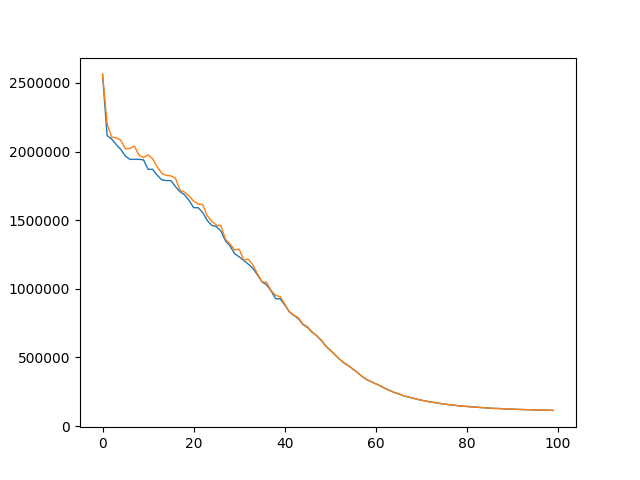

In [28]:
%matplotlib notebook
#%matplotlib notebook
fig1=plt.figure(1)
plt.plot(best_cost_history[graph_results:], linewidth=1, label='best_cost_history')
plt.plot(current_cost_history[graph_results:], linewidth=1, label='current_cost_history')
#plt.yscale('log')
fig1.show()

<IPython.core.display.Javascript object>


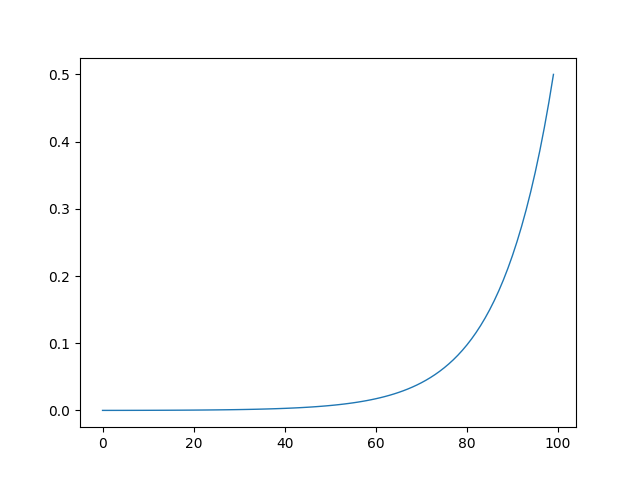

In [29]:
#%matplotlib notebook
fig2=plt.figure(2)
#%matplotlib notebook
plt.plot(beta_history, linewidth=1, label='beta_history')
fig2.show()

<IPython.core.display.Javascript object>


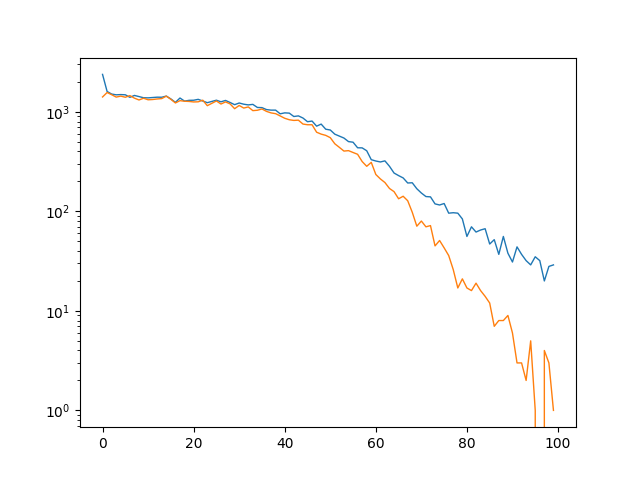

In [30]:
#%matplotlib notebook
fig3=plt.figure(3)
#%matplotlib notebook
plt.plot(optimal_1way_update_history, linewidth=1, label='optimal_1way_update_history')
plt.plot(suboptimal_1way_update_history, linewidth=1, label='suboptimal_1way_update_history')
plt.yscale('log')
fig3.show()

<IPython.core.display.Javascript object>


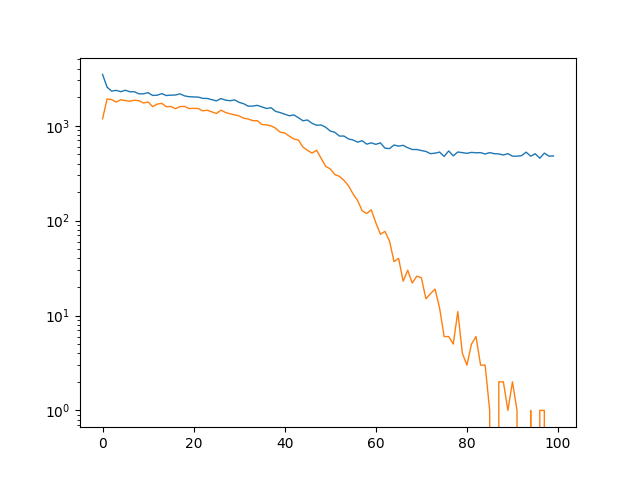

In [31]:
%matplotlib notebook
#%matplotlib notebook
fig4=plt.figure(4)
plt.plot(optimal_swap_update_history, linewidth=1, label='optimal_swap_update_history')
plt.plot(suboptimal_swap_update_history, linewidth=1, label='suboptimal_swap_update_history')
plt.yscale('log')
fig4.show()

<IPython.core.display.Javascript object>


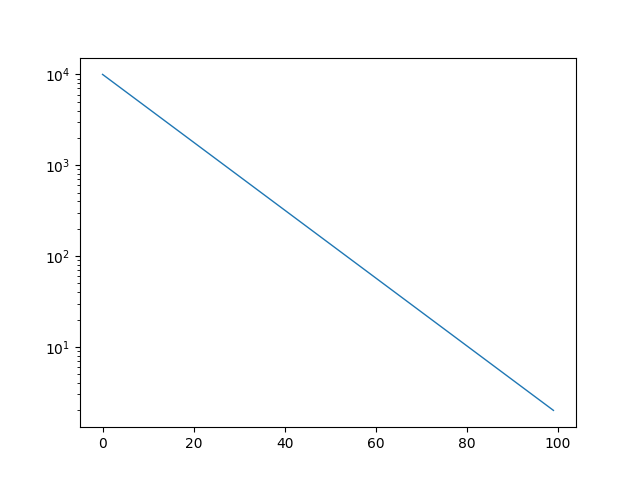

In [26]:
# it is not used in calculations, but is used as a check if the beta's are change so that temperature decreases exponentially
%matplotlib notebook
#%matplotlib notebook
fig5=plt.figure(5)
plt.plot(temperature_history, linewidth=1, label='temperature_history')
plt.yscale('log')
fig5.show()

In [27]:
# showing how much time elapsed in the whole simulation (in seconds)
run_time = end - start
print(run_time)

69.74343776702881
